# Simulating InSAR Noise Data

## 0. Importing Libraries

To simulate the various types of noise and subsidence data in this notebook, we will be constructing 3D numpy arrays and displaying them as images. This will consist of an x and y axis with the third value representing the number value of a pixel.

We will start with a size of 1500x1500.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

size = (1500, 1500)

## 1. Simulating Random Noise as a Gaussian Distribution 

The first and most trivial type of noise we need to add is the random noise. 

We are simulating this as a Gaussian (normal) distribution with $\mu = 0$ and $\sigma = 0.56$. 

In [2]:
def generate_random_noise(size, std=0.56):
    # Return a matrix with a normal distribution with mean at 0 and passed in size/std
    return np.random.normal(loc=0.0, scale=std, size=size)

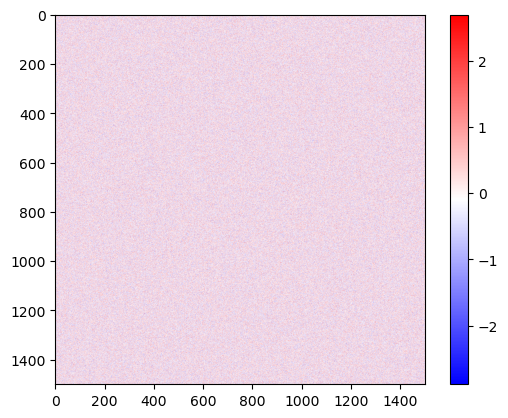

In [3]:
test_gaus = generate_random_noise(size)
plt.imshow(test_gaus, cmap='bwr')
plt.colorbar()

## 2. Simulating Tropospheric Noise

The second type of noise we are simulating is tropospheric noise. 

This noise is slightly different than our Gaussian noise as it's not "White Noise." That is to say, each pixel is not independent in picking from the distribution. Rather, the frequency across the x and y axes determines the noise level at a specific pixel. 

In our case, the distirbution follows the "Power Law" $P(k) \propto k^{-\beta}$, where $k$ is the spatial frequency, and $\beta$ is a constant controlling how quickly power decays with frequency. From the given paper we will use $\beta = 1.82$.

However, because we are dealing discrete pixels (not a continuous distribution) we need to use np.fft.fftfreq() to generate a discrete frequency array for our pixels. We need to do this for both the x and y axis. 

After this we can calculate the radial frequency (circular frequency from the center) by calculating the magnitude as $k = \sqrt{k_{x}^{2} + k_{y}^{2}}$

In [4]:
def generate_tropospheric_noise(size, beta=1.82, scale=1.0):
    # Create a frequency domain based on a standard normal distribution
    noise = np.fft.fft2(np.random.randn(*size)) 

    # Create our discrte frequency distributions over x and y axes
    ky = np.fft.fftfreq(size[0])
    kx = np.fft.fftfreq(size[1])

    # Mesh them together get the specific axes
    kx, ky = np.meshgrid(kx, ky)

    # Compute the radial spatial frequency (frequency from the center)
    k = np.sqrt(kx**2 + ky**2)
    k[0, 0] = 1e-7

    # Calculate the power law
    power = k ** (-beta)

    # Use inverse fourier transform to calculate it back in spatial domain
    frac_noise = np.fft.ifft2(noise * power).real

    # Normalize it
    frac_noise = (frac_noise - frac_noise.mean()) / frac_noise.std()
    return frac_noise * scale

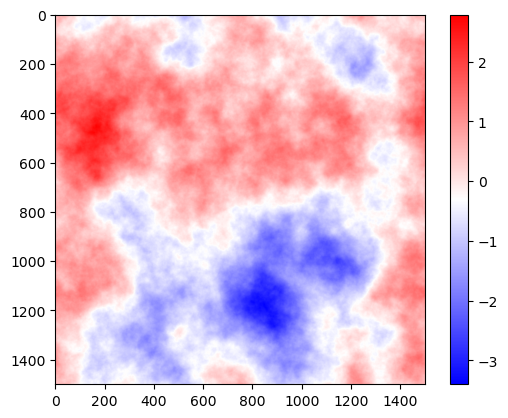

In [5]:
test_trop = generate_tropospheric_noise(size)
plt.imshow(test_trop, cmap='bwr')
plt.colorbar()

# 3. Simulating Subsidence Background

In addition to the noisy data, we need to simulate the "background" of the image itself. Using the synthetic subsidence "Zoback model" outlined in the paper we mathematically calculate what we are aiming to recover with our CNN models.

$u_{r}(r, 0) = -\frac{1}{\pi c_m (1 - v)} \frac{r}{(r^2 + D^2)^\frac{3}{2}} \Delta P_p V$

$u_{z}(r, 0) = -\frac{1}{\pi c_m (1 - v)} \frac{D}{(r^2 + D^2)^\frac{3}{2}} \Delta P_p V$

We are simulating this for a single satellite, so we need to calculate the line-of-sight unit vector to project this calculation on a 2d image. The parameters needed for this are the incidence angle and azimuth angle of the satellite. For now, we assume an azimuth angle of 0 degrees and an incidence angle of 40 degrees. 

Furthermore, because we plan to train the model over a single location with time-series data, we need to adjust our $\Delta P$ (pore pressure) parameter over time.



In [6]:
def calculate_los_vector(incidence_angle_deg, satellite_azimuth_deg):
    incidence_angle_rad = np.deg2rad(incidence_angle_deg)
    satellite_azimuth_rad = np.deg2rad(satellite_azimuth_deg)
    look_azimuth_rad = satellite_azimuth_rad + np.pi/2

    l_east = np.sin(incidence_angle_rad) * np.sin(look_azimuth_rad)
    l_north = np.sin(incidence_angle_rad) * np.cos(look_azimuth_rad)
    l_up = np.cos(incidence_angle_rad)
    return np.array([l_east, l_north, l_up])
    
def generate_subsidence(size, D=50, delta_P=1.0, nu=0.25, cm=1.0, V=1.0, incidence_angle_deg=40, satellite_azimuth_deg=0):
    # Get the indices/center and calculate the radial distance
    y, x = np.indices(size)
    cx, cy = size[1] // 2, size[0] // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2)

    # Calculate the factor and the uz_raw
    factor = (-1 / np.pi) * cm * (1 - nu) * delta_P * V
    uz = factor * (D / ((r**2 + D**2)**1.5))
    ur = factor * (r / ((r**2 + D**2)**1.5))

    # Calculate the azimuth angle
    azimuth = np.arctan2(y - cy, x - cx)

    # Get the x/y components
    ux = ur * np.cos(azimuth)
    uy = ur * np.sin(azimuth)

    # Calculate the line-of-sight (LOS) unit vector
    los_vector = calculate_los_vector(incidence_angle_deg, satellite_azimuth_deg)
    
    # Multiply these by the los unit vector
    simulated_interferogram = (ux * los_vector[0]) + (uy * los_vector[1]) + (uz * los_vector[2])

    return simulated_interferogram

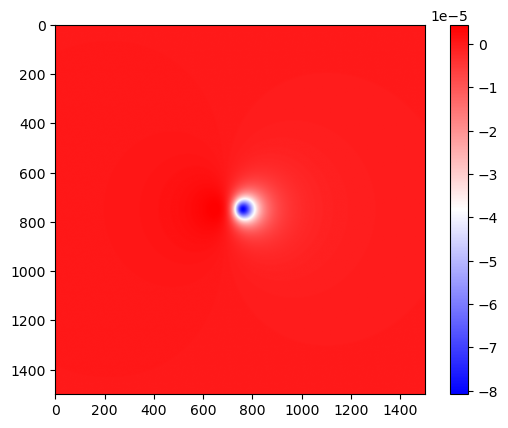

In [7]:
test_sub = generate_subsidence(size)
plt.imshow(test_sub, cmap='bwr')
plt.colorbar()

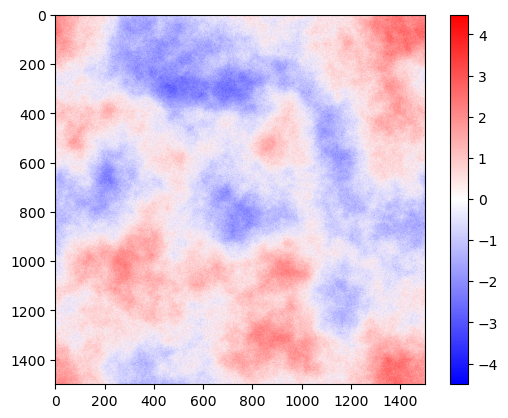

In [8]:
test_img = generate_subsidence(size) + generate_tropospheric_noise(size) + generate_random_noise(size)
plt.imshow(test_img, cmap='bwr')
plt.colorbar()

# 4. Generating Synthetic Time-Series Data

We need to create time-series data based on our simulation to train the model on. For now, the only paramater that we will change is $\Delta P$ or the pore pressure of the subsidence background.

To run a simple experiment, we can iterate over our time series for both logarthimic and linear change in the pore pressure to create varying synthetic time-series data.

First we need to get our time intervals using np.arange.

In [31]:
def get_times(total_days=1460, interval_days=49):
    # Return an array of days of step size interval_days
    return np.arange(0, total_days + 1, interval_days)

times = get_times()
times

array([   0,   49,   98,  147,  196,  245,  294,  343,  392,  441,  490,
        539,  588,  637,  686,  735,  784,  833,  882,  931,  980, 1029,
       1078, 1127, 1176, 1225, 1274, 1323, 1372, 1421])

To create an array representing the linear change in pore pressure over years, we need to first identify what our "max subsidence" is at that time. This would be the subsidence in the center of the circle. This helps us calculate the rate at which the pore pressure should change over time to find that max subsidence.

$A \frac{times[]}{365}$

In [9]:
def linear_displacement(times, A=0.75):
    return A * (times / 365)

lin = linear_displacement(times)
lin

NameError: name 'times' is not defined

To create an array representing the logairhtmic change in displacement, we can multiply the logarithmic decay displacement rate $B$ by the natural log of the year. This was chosen as 1.86 cm / year in the paper.

$B ln(t + 1)$

In [14]:
def log_displacement(times, B=1.86):
    return B * np.log1p(times / 365)

log = log_displacement(times)
log

array([0.        , 0.23430163, 0.44236324, 0.62947472, 0.79947181,
       0.95522458, 1.0989367 , 1.23233694, 1.35680657, 1.47346668,
       1.58323965, 1.68689353, 1.78507464, 1.87833203, 1.96713603,
       2.05189268, 2.13295486, 2.21063125, 2.28519338, 2.35688137,
       2.42590861, 2.49246554, 2.5567229 , 2.61883429, 2.67893844,
       2.73716101, 2.79361626, 2.84840832, 2.90163239, 2.95337572])

If different locations are found to have different displacement rates, or for the purposes of training off a variety of data, we can always adjust the constants or create new formulas for getting these displacement values.

The next step is to actually generate these time series images. This is quite trivial we just need to iterate over our displacement and pass this into our vertical displacement function. 

In [15]:
def generate_linear_timeseries(size, interval_days):
    times = get_times(interval_days=interval_days)
    displacements = linear_displacement(times)
    time_series = []
    for d in displacements:
        uz = generate_vertical_displacement(size, max_disp_cm=d)
        noise = generate_tropospheric_noise(size) + generate_random_noise(size)
        combined = uz + noise
        time_series.append(combined)
        
    return time_series, times

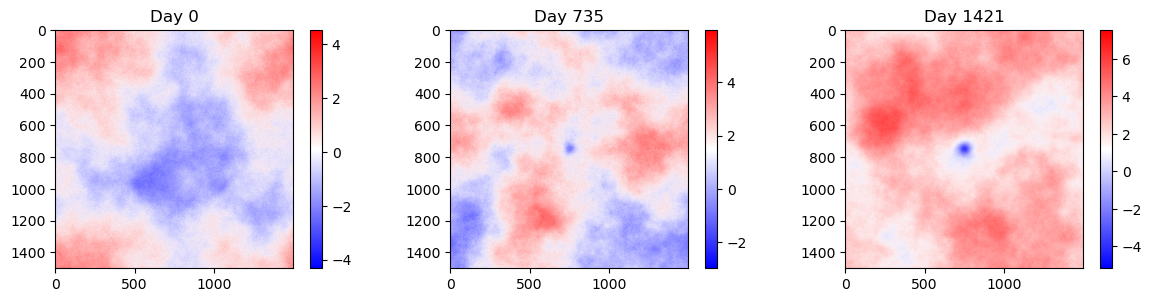

In [16]:
series, times = generate_linear_timeseries(size, interval_days=49)

# Plot a few time steps
plt.figure(figsize=(12, 3))
for i, t in enumerate([0, len(times)//2, -1]):
    plt.subplot(1, 3, i + 1)
    plt.title(f"Day {int(times[t])}")
    plt.imshow(series[t], cmap='bwr')
    plt.colorbar()
plt.tight_layout()
plt.show()

We can do the same with log timeseries.

In [17]:
def generate_log_timeseries(size, interval_days):
    times = get_times(interval_days=interval_days)
    displacements = log_displacement(times)
    time_series = []
    for d in displacements:
        uz = generate_vertical_displacement(size, max_disp_cm=d)
        noise = generate_tropospheric_noise(size) + generate_random_noise(size)
        combined = uz + noise
        time_series.append(combined)
        
    return time_series, times

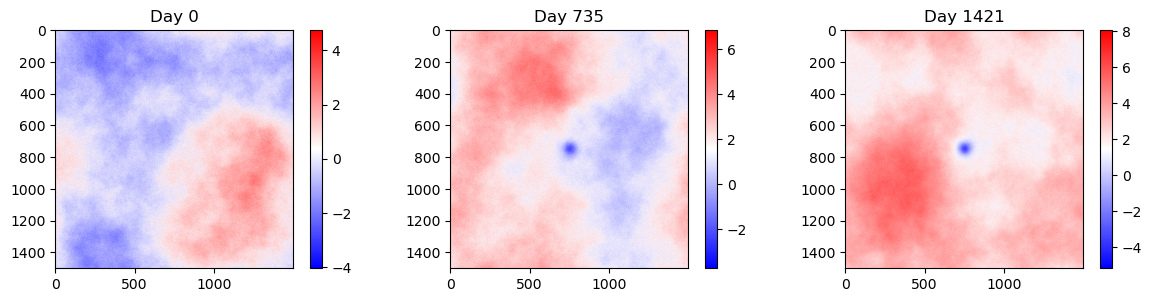

In [18]:
series, times = generate_log_timeseries(size, interval_days=49)

# Plot a few time steps
plt.figure(figsize=(12, 3))
for i, t in enumerate([0, len(times)//2, -1]):
    plt.subplot(1, 3, i + 1)
    plt.title(f"Day {int(times[t])}")
    plt.imshow(series[t], cmap='bwr')
    plt.colorbar()
plt.tight_layout()
plt.show()

We can make this simpler so when we build our data generation class we can input "linear" or "log" to generate the type of data we need.

In [19]:
def generate_timeseries(size, mode="linear", interval_days=49):
    if(mode == "linear"):
        time_series, times = generate_linear_timeseries(size, interval_days)
    elif(mode == "log"):
        time_series, times = generate_log_timeseries(size, interval_days)
    else:
        print("Incorrect Mode Type")
    return time_series, times

## 6. Designing a Class for Generating Pairs of Noisy Data

We can start adding all the functions we created into a class for easy generation of pairs of data. This will allow us to easily wrap it in a "Dataset" class from Pytorch or tensorflow to have easy data loading.

In [20]:
class InSARDataGenerator:
    def __init__(self, size=(1500,1500), model='linear', interval_days=49, 
                 duration_days=1460, std=0.56, beta=1.82, rate=0.75):
        # Initialize class with given params
        self.size = size
        self.model = model
        self.interval_days = interval_days
        self.duration_days = duration_days
        self.std = std
        self.beta = beta
        self.rate = rate
        self.times = np.arange(0, self.duration_days + 1, self.interval_days)

    def __len__(self):
        # Get the length of the dataset as the length of time (since its time-series)
        return len(self.times)

    def get_displacement(self, day):
        # Calculate the max_displacement for a given day using the dataset type
        if self.model == "linear":
            max_disp = self.rate * (day / 365)
        elif self.model == "log":
            max_disp = self.rate * np.log1p(day / 365)
        else:
            raise ValueError("Unknown displacement type")
        return self._generate_vertical_displacement(max_disp)

    def _generate_vertical_displacement(self, max_disp_cm):
        # Get the indices per axis
        y, x = np.indices(self.size)
        
        # Get the center points
        cx, cy = self.size[1] // 2, self.size[0] // 2

        # Calculate the radial distance between each point
        r = np.sqrt((x - cx)**2 + (y - cy)**2)

        # Apply the formula with our constants
        D, nu, cm, delta_P, V = 50, 0.25, 1.0, 1.0, 1.0
        factor = -1 / (np.pi * cm * (1 - nu)) * delta_P * V
        uz_raw = factor * (D / ((r**2 + D**2)**1.5))

        min_val = np.min(uz_raw)

        A = -2 * max_disp_cm / min_val
        B = max_disp_cm

        uz = A * uz_raw + B
        return uz

    '''
    def _generate_topographic_dem_noise(self, dem_error_std_dev=5, wavelength=0.056, perpendicular_baseline=100.0, slant_range=800000.0, incidence_angle_deg=35.0):
        delta_h = np.random.randn(*self.size) * dem_error_std_dev
        incidence_angle_rad = np.deg2rad(incidence_angle_deg)
        K = (4 * np.pi * perpendicular_baseline) / (wavelength * slant_range * np.sin(incidence_angle_rad))
        phi_topo_res = K * delta_h
        return phi_topo_res
    '''

    def _generate_tropospheric_noise(self):
        # Get discrete frequencies given the size
        noise = np.fft.fft2(np.random.randn(*self.size))
        ky = np.fft.fftfreq(self.size[0])
        kx = np.fft.fftfreq(self.size[1])
        kx, ky = np.meshgrid(kx, ky)

        # Calculate magnitude of k given its components
        k = np.sqrt(kx**2 + ky**2)

        # Apply the formula to get the actual noise image
        k[0, 0] = 1e-6
        power = k ** (-self.beta)
        frac_noise = np.fft.ifft2(noise * power).real
        frac_noise = (frac_noise - frac_noise.mean()) / frac_noise.std()
        return frac_noise

    def _generate_uncorrelated_noise(self):
        # Get a guassian distribution with mean=0 and std=std for our img
        return np.random.normal(0, self.std, size=self.size)

    def __getitem__(self, index):
        # Return a pair of noisy images based on the same displacement (same day)
        day = self.times[index]
        clean = self.get_displacement(day)
        noisy_1 = clean + self._generate_tropospheric_noise() + self._generate_uncorrelated_noise() #+ self._generate_topographic_dem_noise()
        noisy_2 = clean + self._generate_tropospheric_noise() + self._generate_uncorrelated_noise() #+ self._generate_topographic_dem_noise()
        return noisy_1, noisy_2

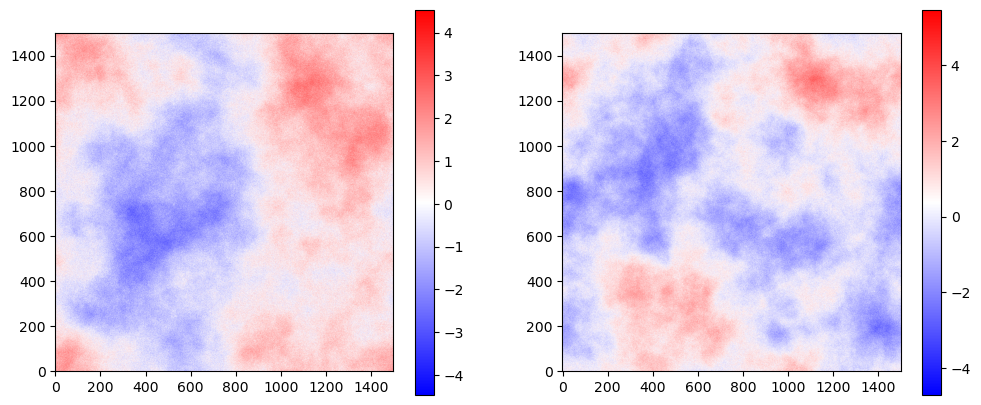

In [21]:
ds = InSARDataGenerator(model='linear', interval_days=14.7)

x, y = ds[0]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(x, cmap='bwr', origin='lower')
plt.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(y, cmap='bwr', origin='lower')
plt.colorbar(im2, ax=axes[1])

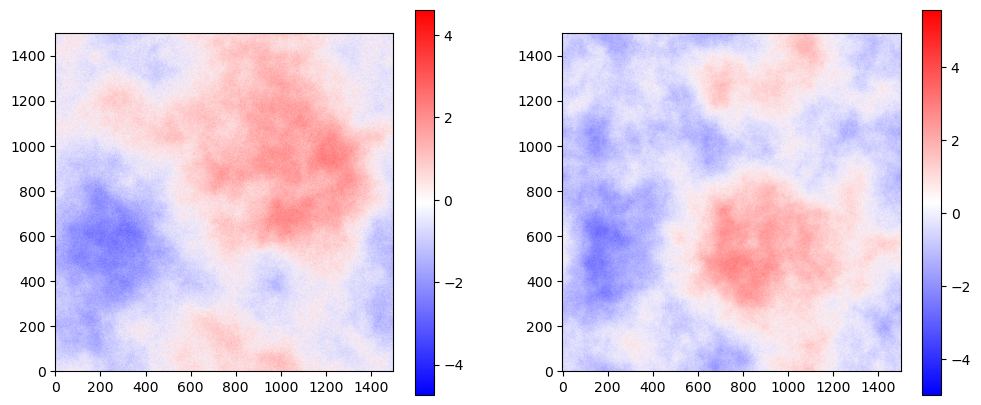

In [22]:
ds = InSARDataGenerator(model='log', interval_days=14.7)

x, y = ds[0]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im1 = axes[0].imshow(x, cmap='bwr', origin='lower')
plt.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(y, cmap='bwr', origin='lower')
plt.colorbar(im2, ax=axes[1])